In [315]:
import sys
# sys.path.insert(0, "./")
# sys.path.insert(0, "../../")
import torch
from torch.utils.data import Dataset
from utils import *
import random
import matplotlib.pyplot as plt

from torchvision.models import resnet50, resnet18
import argparse
import traceback
import seaborn as sns
import pandas as pd
import csv
import ast
import pdb

In [316]:
GRID_SIZE =6
time_out = 600
assumed_behavior = "HUMAN"

In [317]:
display_label = {
    "BLOCKING_ONLY_EXHAUSTIVE":"Exhaustive",
    "BLOCKING_ONLY_PRUNE_REDUCE": "Pruned-Reduce",
    "BLOCKING_ONLY_GREEDY_TRUE_WCD":"Greedy (true wcd)",
    "BLOCKING_ONLY_GREEDY_PRED_WCD":"Greedy (predicted wcd)",
    "BLOCKING_ONLY_test":"Our approach",
    "ALL_MODS_EXHAUSTIVE":"Exhaustive",
    "ALL_MODS_GREEDY_PRED_WCD":"Greedy (predicted wcd)",
    "ALL_MODS_GREEDY_TRUE_WCD":"Greedy (true wcd)",
    "ALL_MODS_test":"Our approach",
    "BOTH_UNIFORM_EXHAUSTIVE":"Exhaustive",
    "BOTH_UNIFORM_GREEDY_TRUE_WCD":"Greedy(data-driven)",
    "BOTH_UNIFORM_GREEDY_PRED_WCD":"Greedy (predicted wcd)",
    "OPTIMAL_BOTH_UNIFORM_test":"Our approach (optimal)",
    "HUMAN_BOTH_UNIFORM_test": "Our approach(data-driven)"
    
}

display_label_colors = {
    "BLOCKING_ONLY_EXHAUSTIVE": "#333333",  # A blackish color
    "BLOCKING_ONLY_PRUNE_REDUCE": "#d95f02",  # An orangish color
    "BLOCKING_ONLY_GREEDY_TRUE_WCD": "#7570b3",  # A bluish color
    "BLOCKING_ONLY_GREEDY_PRED_WCD": "#e7298a",  # A crimson-like pink color
    "BLOCKING_ONLY_test": "#66a61e",  # A grass green color
    "ALL_MODS_EXHAUSTIVE": "#333333",  # A golden color
    "ALL_MODS_GREEDY_PRED_WCD": "#e7298a",   # A crimson-like pink color
    "ALL_MODS_GREEDY_TRUE_WCD": "#7570b3",  # A bluish color
    "ALL_MODS_test": "#66a61e",  # A grass green color
    "BOTH_UNIFORM_EXHAUSTIVE": "#333333",  # A golden color
    "BOTH_UNIFORM_GREEDY_PRED_WCD": "#e7298a",   # A crimson-like pink color
    "BOTH_UNIFORM_GREEDY_TRUE_WCD": "#7570b3",  # A bluish color
    "OPTIMAL_BOTH_UNIFORM_test": "#1b9e77",  # A grass green color
    "HUMAN_BOTH_UNIFORM_test": "#66a61e"  # A grass green color
}


In [318]:
experiment_label ="BLOCKING_ONLY_EXHAUSTIVE" 
cost = 0
base_data_dir = "./baselines/data" #"./data"


def extract_labels(folder_path, grid_size = 6):
     # List to hold folder names
    folder_names = []

    # Iterate over all entries in the given folder
    for entry in os.listdir(folder_path):
        # Check if it's a directory
        full_path = os.path.join(folder_path, entry)
        if os.path.isdir(full_path):
            # Add the folder name to the list
            if entry in display_label.keys():
                folder_names.append(entry)

    return folder_names

In [319]:
def read_env_data(file_name):
    with open(file_name, "rb") as f:
        loaded_dataset = pickle.load(f)
        x_data = []
        y_data = []
        for i in range(loaded_dataset. __len__()):

            x_data.append(loaded_dataset[i][0].unsqueeze(0))
            y_data.append(loaded_dataset[i][1].unsqueeze(0))

        x_init_data = torch.cat(x_data).numpy()
        y_init_data = torch.cat(y_data).numpy()
        
    return x_init_data, y_init_data

def read_csv(filename):
    """
    Reads numbers from a CSV file and returns them as a list of lists.

    Args:
    filename (str): The name of the CSV file.

    Returns:
    list of lists: Each sublist contains numbers from a row in the CSV file.
    """
    data = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Convert each string in the row to an integer
            number_row = [ast.literal_eval(item) for item in row]
            data.append(number_row)
    return data 

In [320]:
from scipy.interpolate import make_interp_spline
from scipy.ndimage import uniform_filter1d
def moving_average(data, window_size):
    return uniform_filter1d(data, size=window_size, mode='reflect')

def plot_summary(df, ylabel, title, show_std_err=True, filename=None, use_given_budget=True, smoothing_window=4, 
                 use_log_scale=False, show_title=False):
    selections = None
    lw = 4
    font_size = 65
    fig_size = (20, 16)
    
    # Check if "time" is in ylabel
    if "Time" in ylabel:
        # Create two separate plots
        fig, axes = plt.subplots(figsize=fig_size, dpi=300, constrained_layout=True)

        for label, row in df.iterrows():
            print(label)
            data = pd.DataFrame({
                'budget': row['given_budget'] if use_given_budget else row['realized_budget'],
                'mean': row['mean']
            })
            
            
            # Plot other curves on the second plot
            legend_label = f"{display_label[label]}(n={row['n']})"
            legend_label = f"{display_label[label]}"
            

            # Group by 'budget' and calculate timeout statistics
            print(time_out)
            timeout_data = data.groupby('budget')['mean'].agg(['count', lambda x: (x >= time_out).sum()]).reset_index()
            timeout_data.columns = ['budget', 'total_count', 'count_timeout']
            
            # Calculate percentage timeout for each budget
            timeout_data['percentage_timeout'] = (timeout_data['count_timeout'] / timeout_data['total_count']) * 100
            
            timeout_data = timeout_data[timeout_data["budget"] < 20]
            print(timeout_data)

#             # Plot the percentage timeout curve on the first plot
#             axes[0].errorbar(timeout_data['budget'], timeout_data['percentage_timeout'], fmt='-o',
#                              capsize=1, label=legend_label, color=display_label_colors[label])
            
#             axes[0].set_ylabel("Percentage Timeout")
            
#             axes[0].set_xlabel("budget")
#             axes[0].legend(fontsize=10)
#             axes[0].set_title(title)

            # Group by 'budget' and calculate standard error of the mean
            grouped_data = data.groupby('budget')['mean'].agg(['mean', 'sem', "count"]).reset_index()
            print(grouped_data)

            # Apply log scale if specified
            if use_log_scale:
                grouped_data['sem'] = grouped_data['sem'] / grouped_data['mean']
                grouped_data["mean"] = np.log10(grouped_data["mean"])

            # Filter out data points with budget greater than 20 and count less than 1
            if GRID_SIZE == 6:
                grouped_data = grouped_data[grouped_data["budget"] <21]
            grouped_data = grouped_data[grouped_data["count"] > 1]

            # Apply smoothing if specified
            if smoothing_window:
                grouped_data['mean'] = moving_average(grouped_data['mean'], smoothing_window)

            
            axes.errorbar(grouped_data['budget'], grouped_data['mean'], yerr=grouped_data['sem'], fmt='-o',
                             capsize=1, label=legend_label, color=display_label_colors[label],linewidth = lw)
            if show_std_err:
                axes.fill_between(grouped_data["budget"], grouped_data['mean'] - grouped_data['sem'],
                                      grouped_data['mean'] + grouped_data['sem'], alpha=0.2,
                                      color=display_label_colors[label])

            # Set common xlabel, legend, and title for both plots
            axes.set_ylabel(ylabel,fontsize = font_size)
            axes.set_xlabel("budget",fontsize = font_size)
            axes.legend(fontsize=font_size)
            plt.xticks(fontsize =font_size)
            plt.yticks(fontsize =font_size)
            axes.tick_params(axis='both', which='major', length=font_size/2)
            if show_title:
                axes.set_title(title)
        

    else:
        # Create a single plot
        fig, ax = plt.subplots(figsize=fig_size, dpi=300, constrained_layout=True)

        for label, row in df.iterrows():
            print(label)
            legend_label = f"{display_label[label]}(n={row['n']})"
            data = pd.DataFrame({
                'budget': row['given_budget'] if use_given_budget else row['realized_budget'],
                'mean': row['mean']
            })
            

            # Group by 'budget' and calculate standard error of the mean
            grouped_data = data.groupby('budget')['mean'].agg(['mean', 'sem', "count"]).reset_index()
            print(grouped_data)

            # Apply log scale if specified
            if use_log_scale:
                grouped_data['sem'] = grouped_data['sem'] / grouped_data['mean']
                grouped_data["mean"] = np.log10(grouped_data["mean"])

            # Filter out data points with budget greater than 20 and count less than 1
            if GRID_SIZE == 6:
                grouped_data = grouped_data[grouped_data["budget"] <21]
                grouped_data = grouped_data[grouped_data["budget"] %2 ==1]
            grouped_data = grouped_data[grouped_data["count"] > 1]

            # Apply smoothing if specified
            if smoothing_window:
                grouped_data['mean'] = moving_average(grouped_data['mean'], smoothing_window)

            # Plot other curves on the single plot
            legend_label = f"{display_label[label]}(n={row['n']})"
            legend_label = f"{display_label[label]}"
            ax.errorbar(grouped_data['budget'], grouped_data['mean'], yerr=grouped_data['sem'], fmt='-o',
                        capsize=1, label=legend_label, color=display_label_colors[label],linewidth = lw)
            if show_std_err:
                ax.fill_between(grouped_data["budget"], grouped_data['mean'] - grouped_data['sem'],
                                 grouped_data['mean'] + grouped_data['sem'], alpha=0.2,
                                 color=display_label_colors[label])
            if "test" in label:
                label = f"{label}_{str(N_LAMBDA).zfill(3)}"
            grouped_data.to_csv(f"plots/{label}.csv")

        # Set xlabel, legend, and title for single plot
        ax.set_xlabel("budget",fontsize = font_size+5)
        ax.set_ylabel(ylabel, fontsize = font_size+5)
        # ax.set_ylim(0)
        plt.xticks(range(0,20,5),fontsize =font_size)
        plt.yticks(fontsize =font_size)
        ax.legend(fontsize=font_size)
        ax.tick_params(axis='both', which='major', length=font_size/2)
        if show_title:
            ax.set_title(title)
        
        

    # Save and show plot(s)
    plt.tight_layout()
    
    if filename:
        plt.savefig(f"./plots/{filename}", dpi=500, bbox_inches='tight')
    plt.show()


In [321]:
# Initialize DataFrames to store summary data
columns = ["Experiment Label","n",'mean', 'std_err',"given_budget", "realized_budget"]
time_summary = pd.DataFrame(columns=columns)
wcd_summary = pd.DataFrame(columns=columns)
percent_completed_summary = pd.DataFrame(columns=columns)
percent_reduced_summary = pd.DataFrame(columns=columns)

In [322]:
results_df = pd.DataFrame(columns=["Experiment Label","Grid Size","n","Mean Time (sd)", "Mean Time (s)",  "% Completed", "% Reduced", "Mean WCD Reduction (sd)","Mean WCD Reduction"])
experiment_labels = extract_labels(f"./data/grid{GRID_SIZE}/HUMAN", grid_size = GRID_SIZE )+extract_labels(f"./data/grid{GRID_SIZE}/OPTIMAL", grid_size = GRID_SIZE )+ extract_labels(f"./baselines/data/grid{GRID_SIZE}/timeout_{time_out}/HUMAN", grid_size = GRID_SIZE)
experiment_labels = sorted(experiment_labels,reverse=False)

In [323]:
USE_COMPLETED_ONLY = True
if GRID_SIZE ==10:
    select_idx_blocking_only = 11 # 62#63
    select_idx_all_mods = 11 #224 #159 #63
    select_idx_both_uniform = 11 #224 # 235 #340
else: # Grid size = 6
    select_idx_blocking_only = 150# 62#63
    select_idx_all_mods = 150 #224 #159 #63
    select_idx_both_uniform = 150 #224 # 235 #340

    
    ratio = "ratio_3_1"
    N_LAMBDA = 289

In [324]:
if  GRID_SIZE >= 10:#and USE_COMPLETED_ONLY:
    # Assuming experiment_labels is a list containing your labels
    # Use list comprehension to filter out labels containing "EXHAUSTIVE"
    experiment_labels = [label for label in experiment_labels if "EXHAUSTIVE" not in label or "BLOCKING_ONLY" in label] #or "BLOCKING_ONLY" in label

In [325]:
selections_blocking_only = np.array([True]*select_idx_blocking_only)
selections_both_uniform = np.array([True]*select_idx_both_uniform)
selections_all_mods = [True]*select_idx_all_mods
for experiment_label in experiment_labels:
    if "PRED_WCD" in experiment_label: continue 
    if experiment_label in ["HUMAN_BOTH_UNIFORM_test","OPTIMAL_BOTH_UNIFORM_test"]:
        assumed_behavior_dir = "OPTIMAL" if "OPTIMAL" in experiment_label else "HUMAN"
        base_data_dir = f"./data/grid{GRID_SIZE}/{assumed_behavior_dir}/{experiment_label}" #"./data"
        if "ALL_MODS" in experiment_label:
            base_data_dir = f"{base_data_dir}/{ratio}/"
        if not ( "BOTH_UNIFORM_test"in experiment_label):
            base_data_dir = f"{base_data_dir}/n_lambdas_{N_LAMBDA}"
        else:
            base_data_dir = f"{base_data_dir}/n_lambdas_{int(np.sqrt(N_LAMBDA))}"
            
    else:
        base_data_dir = f"./baselines/data/grid{GRID_SIZE}/timeout_{time_out}/HUMAN/{experiment_label}/" #"./data"
        if "ALL_MODS" in experiment_label:
            base_data_dir = f"{base_data_dir}/{ratio}/"
    
    
    if "BLOCKING_ONLY" in experiment_label:
        select_idx = len(selections_blocking_only)
    elif "BOTH_UNIFORM" in experiment_label:
        select_idx = len(selections_both_uniform)
    else:
        select_idx = len(selections_all_mods)
        
    times = np.array(read_csv(f'{base_data_dir}/times_{GRID_SIZE}_{experiment_label}.csv'))
    print(experiment_label, "Before:",times.shape)
    times=times[0:select_idx]
    print(times.shape)
    # Store in DataFrames
    if experiment_label in ["HUMAN_BOTH_UNIFORM_test","OPTIMAL_BOTH_UNIFORM_test"]:
        continue
    else:
        if "BLOCKING_ONLY" in experiment_label:
            selections_blocking_only  = np.logical_and(selections_blocking_only, (times<time_out).all(axis = 1))
            # print((times<time_out).any(axis = 1))
        elif "BOTH_UNIFORM" in experiment_label:
            selections_both_uniform  = np.logical_and(selections_both_uniform, (times<time_out).all(axis = 1))
        else:
            print(experiment_label)
            selections_all_mods  = np.logical_and(selections_all_mods, (times<time_out).all(axis = 1))
        

BOTH_UNIFORM_GREEDY_TRUE_WCD Before: (150, 19)
(150, 19)
HUMAN_BOTH_UNIFORM_test Before: (150, 21)
(150, 21)
OPTIMAL_BOTH_UNIFORM_test Before: (150, 21)
(150, 21)


In [326]:
if not USE_COMPLETED_ONLY: # use all without filtering timed out
    selections_blocking_only = np.array([True]*select_idx_blocking_only)
    selections_both_uniform = np.array([True]*select_idx_both_uniform)
    selections_all_mods = np.array([True]*select_idx_all_mods)

In [327]:
for experiment_label in experiment_labels:
    if "PRED_WCD" in experiment_label: continue
    # if experiment_label == "BOTH_UNIFORM_test": continue
    if experiment_label in ["HUMAN_BOTH_UNIFORM_test","OPTIMAL_BOTH_UNIFORM_test"]:
        assumed_behavior_dir = "OPTIMAL" if "OPTIMAL" in experiment_label else "HUMAN"
        base_data_dir = f"./data/grid{GRID_SIZE}/{assumed_behavior_dir}/{experiment_label}" #"./data"
        if "ALL_MODS" in experiment_label:
            base_data_dir = f"{base_data_dir}/{ratio}/"
        if  not ( "BOTH_UNIFORM_test"in experiment_label):
            base_data_dir = f"{base_data_dir}/n_lambdas_{N_LAMBDA}"
        else:
            base_data_dir = f"{base_data_dir}/n_lambdas_{int(np.sqrt(N_LAMBDA))}"
        
    else:
        base_data_dir = f"./baselines/data/grid{GRID_SIZE}/timeout_{time_out}/HUMAN/{experiment_label}" #"./data"
        if "ALL_MODS" in experiment_label:
            base_data_dir = f"{base_data_dir}/{ratio}/"
    

    times = read_csv(f'{base_data_dir}/times_{GRID_SIZE}_{experiment_label}.csv')
    budgets = read_csv(f'{base_data_dir}/budgets_{GRID_SIZE}_{experiment_label}.csv')
    wcd_change = read_csv(f'{base_data_dir}/wcd_change_{GRID_SIZE}_{experiment_label}.csv')

    budget = np.array(budgets).flatten()
    time_raw = np.array(times)
    times = np.array(times)

    wcd_change = np.array(wcd_change)

    budget = np.array(budgets).flatten()
    times = np.array(times)
    wcd_change = np.array(wcd_change)
        
    if "BLOCKING_ONLY" in experiment_label:
        selections  = selections_blocking_only
        select_idx = selections_blocking_only.shape[0]
    elif "BOTH_UNIFORM" in experiment_label:
        selections  = selections_both_uniform
        select_idx = selections_both_uniform.shape[0]
    else:
        selections  = selections_all_mods
        select_idx = selections_all_mods.shape[0]

    # Store in DataFrames
    if experiment_label in ["HUMAN_BOTH_UNIFORM_test","OPTIMAL_BOTH_UNIFORM_test"]:
        # if experiment_label== "ALL_MODS_test": continue
        print(experiment_label)
        budgets = read_csv(f'{base_data_dir}/budgets_{GRID_SIZE}_{experiment_label}.csv')
        budgets = np.array(budgets)
        max_budgets = np.array(read_csv(f'{base_data_dir}/max_budgets_{GRID_SIZE}_{experiment_label}.csv'))[0]
        
        wcd_change = np.array(wcd_change)[0:select_idx][selections]
        times = times[0:select_idx][selections]
        budgets = budgets[0:select_idx][selections]
        
        # print(budgets.shape)
        
        flattened_times = times.flatten()
        flattened_wcd_changes = wcd_change.flatten()
        flattened_realized_budgets = budgets.flatten()
        flattened_given_budgets =np.tile(max_budgets, times.shape[0])
        n = times.shape[0]
        
        print(flattened_wcd_changes.shape,flattened_given_budgets.shape,flattened_times.shape)
        time_summary.loc[experiment_label] = [experiment_label,n,flattened_times, flattened_times,flattened_given_budgets, flattened_realized_budgets]
        wcd_summary.loc[experiment_label] = [experiment_label,n,flattened_wcd_changes, flattened_wcd_changes,flattened_given_budgets, flattened_realized_budgets]
    else:
        print(experiment_label)
        wcd_change= wcd_change[0:select_idx][selections]# only envs that completed
        n = times.shape[0]
        #ONLY those that completed
        realized_budgets = np.array(read_csv(f'{base_data_dir}/num_changes_{GRID_SIZE}_{experiment_label}.csv')).sum(axis =2)[0:select_idx][selections]
        #.flatten()
        given_budget = np.array(read_csv(f'{base_data_dir}/max_budgets_{GRID_SIZE}_{experiment_label}.csv')*n)[0:select_idx][selections]
        times= times[0:select_idx][selections]
        

        n = times.shape[0]
        print(wcd_change.shape,given_budget.shape,times.shape)
        # break
        time_summary.loc[experiment_label] = [experiment_label,n,times.flatten(), times.flatten(),given_budget.flatten(),realized_budgets.flatten()]
        wcd_summary.loc[experiment_label] = [experiment_label,n,wcd_change.flatten(), wcd_change.flatten(),given_budget.flatten(),realized_budgets.flatten()]

BOTH_UNIFORM_GREEDY_TRUE_WCD
(150, 19) (150, 19) (150, 19)
HUMAN_BOTH_UNIFORM_test
(3150,) (3150,) (3150,)
OPTIMAL_BOTH_UNIFORM_test
(3150,) (3150,) (3150,)


In [328]:
# given_budget

In [329]:
time_summary_uniform_df = time_summary[time_summary['Experiment Label'].str.contains("UNIFORM")]
wcd_summary_uniform_df = wcd_summary[wcd_summary['Experiment Label'].str.contains("UNIFORM")]

# Splitting the DataFrame based on experiment labels
time_summary_blocking_df = time_summary[time_summary['Experiment Label'].str.contains("BLOCKING")]
wcd_summary_blocking_df = wcd_summary[wcd_summary['Experiment Label'].str.contains("BLOCKING")]

time_summary_all_mods_df = time_summary[time_summary['Experiment Label'].str.contains("ALL_MODS")]
wcd_summary_all_mods_df = wcd_summary[wcd_summary['Experiment Label'].str.contains("ALL_MODS")]

In [330]:
use_given_budget = True
smoothing_window=2
show_title = False
file_type = "pdf"
# # Plotting Time
# plot_summary(time_summary_all_mods_df, 'Mean Log Time (s)', f'Ratio constrained Modifications ({ratio[-3]}:{ratio[-1]})',
#              use_given_budget = use_given_budget,use_log_scale = True,show_std_err= True, show_title=show_title,
#             filename =f"time/time_{GRID_SIZE}_{time_out}_ratio_constrained{file_type}",smoothing_window=smoothing_window)

# plot_summary(wcd_summary_all_mods_df, 'WCD Reduction', f'Ratio constrained Modifications ({ratio[-3]}:{ratio[-1]})',
#              use_given_budget = use_given_budget, show_title=show_title,
#             filename =f"wcd_reduction/reduction_{GRID_SIZE}_{time_out}_ratio_constrained{file_type}",smoothing_window=smoothing_window)


In [331]:

# # Plotting Time
# plot_summary(time_summary_blocking_df, 'Mean Log Time (s)', f'Blocking Only',
#              use_given_budget = use_given_budget, show_std_err= False,show_title=show_title,
#              filename =f"time/time_{GRID_SIZE}_{time_out}_blocking.{file_type}",use_log_scale = True,smoothing_window=smoothing_window)

# # Plotting WCD Change
# plot_summary(wcd_summary_blocking_df, 'wcd reduction', f'Blocking only',
#              use_given_budget = use_given_budget,show_title=show_title,
#             filename =f"wcd_reduction/reduction_{GRID_SIZE}_{time_out}_blocking.{file_type}",smoothing_window=smoothing_window)


BOTH_UNIFORM_GREEDY_TRUE_WCD
600
    budget  total_count  count_timeout  percentage_timeout
0        1          150              0                 0.0
1        2          150              0                 0.0
2        3          150              0                 0.0
3        4          150              0                 0.0
4        5          150              0                 0.0
5        6          150              0                 0.0
6        7          150              0                 0.0
7        8          150              0                 0.0
8        9          150              0                 0.0
9       10          150              0                 0.0
10      11          150              0                 0.0
11      12          150              0                 0.0
12      13          150              0                 0.0
13      14          150              0                 0.0
14      15          150              0                 0.0
15      16          150

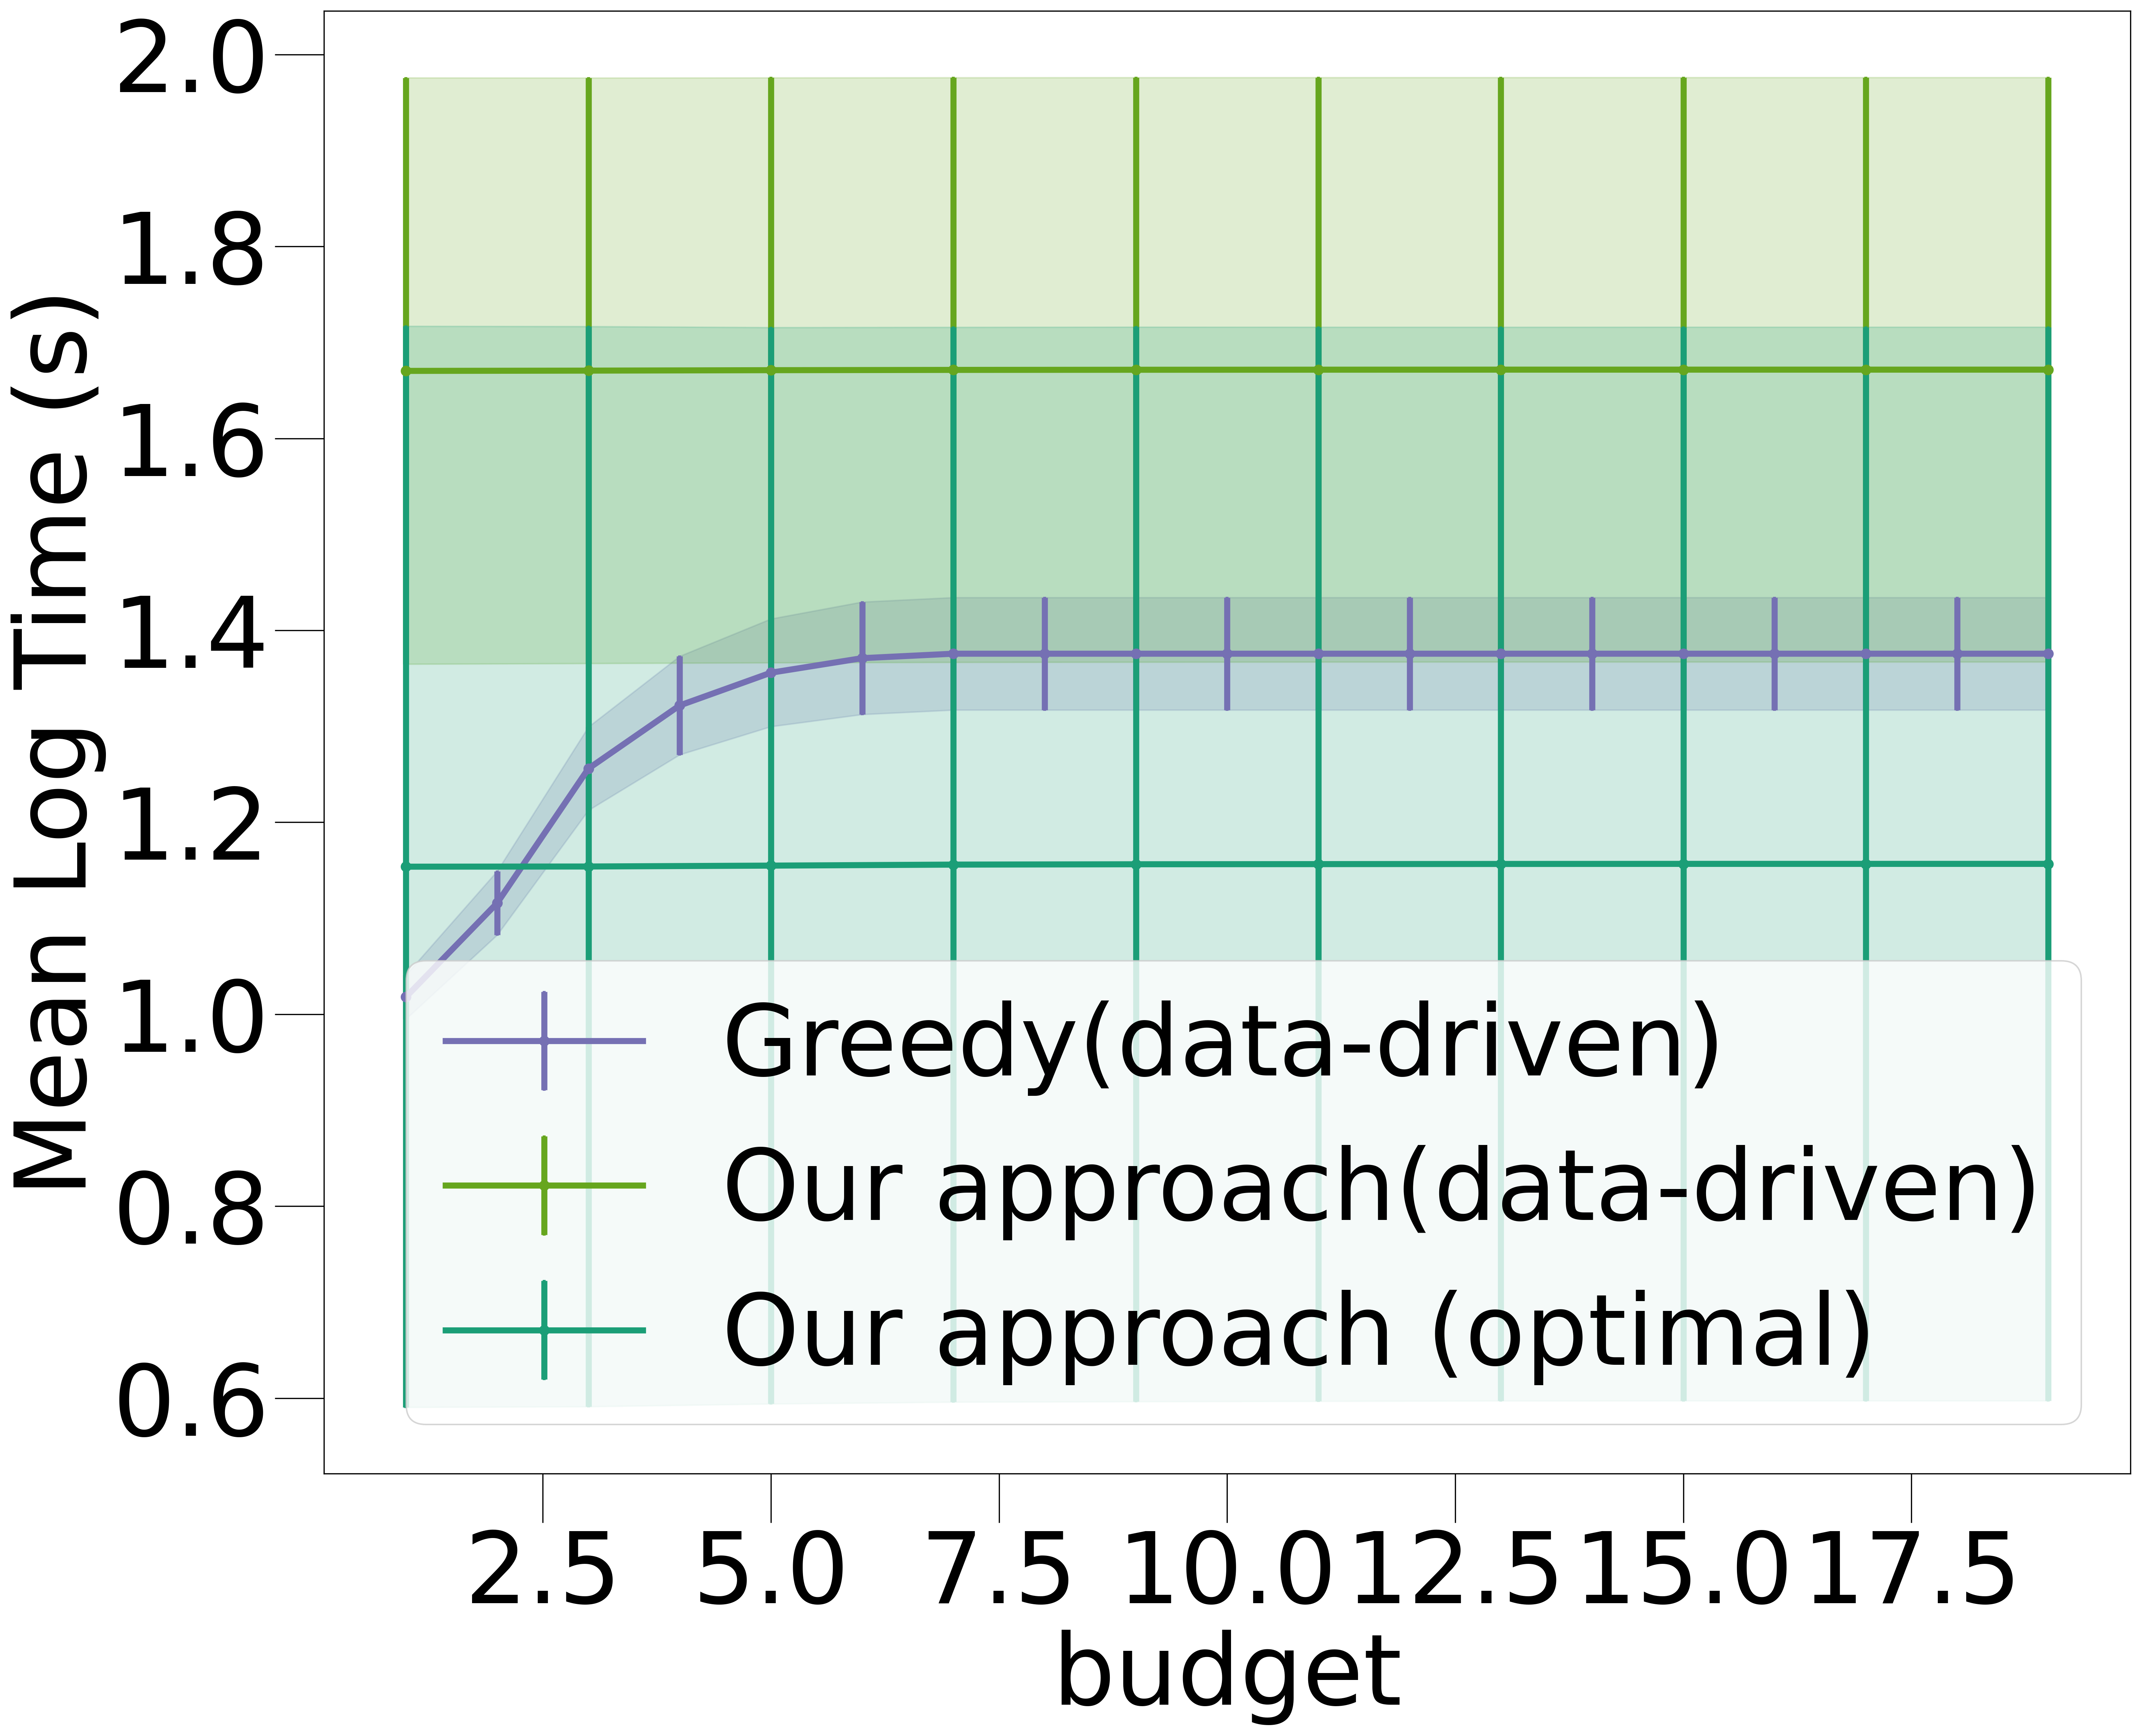

BOTH_UNIFORM_GREEDY_TRUE_WCD
    budget      mean       sem  count
0        1  1.433333  0.155846    150
1        2  1.940000  0.194380    150
2        3  2.266667  0.218530    150
3        4  2.473333  0.235866    150
4        5  2.553333  0.243674    150
5        6  2.586667  0.246712    150
6        7  2.586667  0.246712    150
7        8  2.586667  0.246712    150
8        9  2.586667  0.246712    150
9       10  2.586667  0.246712    150
10      11  2.586667  0.246712    150
11      12  2.586667  0.246712    150
12      13  2.586667  0.246712    150
13      14  2.586667  0.246712    150
14      15  2.586667  0.246712    150
15      16  2.586667  0.246712    150
16      17  2.586667  0.246712    150
17      18  2.586667  0.246712    150
18      19  2.586667  0.246712    150
HUMAN_BOTH_UNIFORM_test
    budget      mean       sem  count
0        1  1.180000  0.154303    150
1        3  2.066667  0.202151    150
2        5  2.733333  0.236618    150
3        7  3.060000  0.247806    1

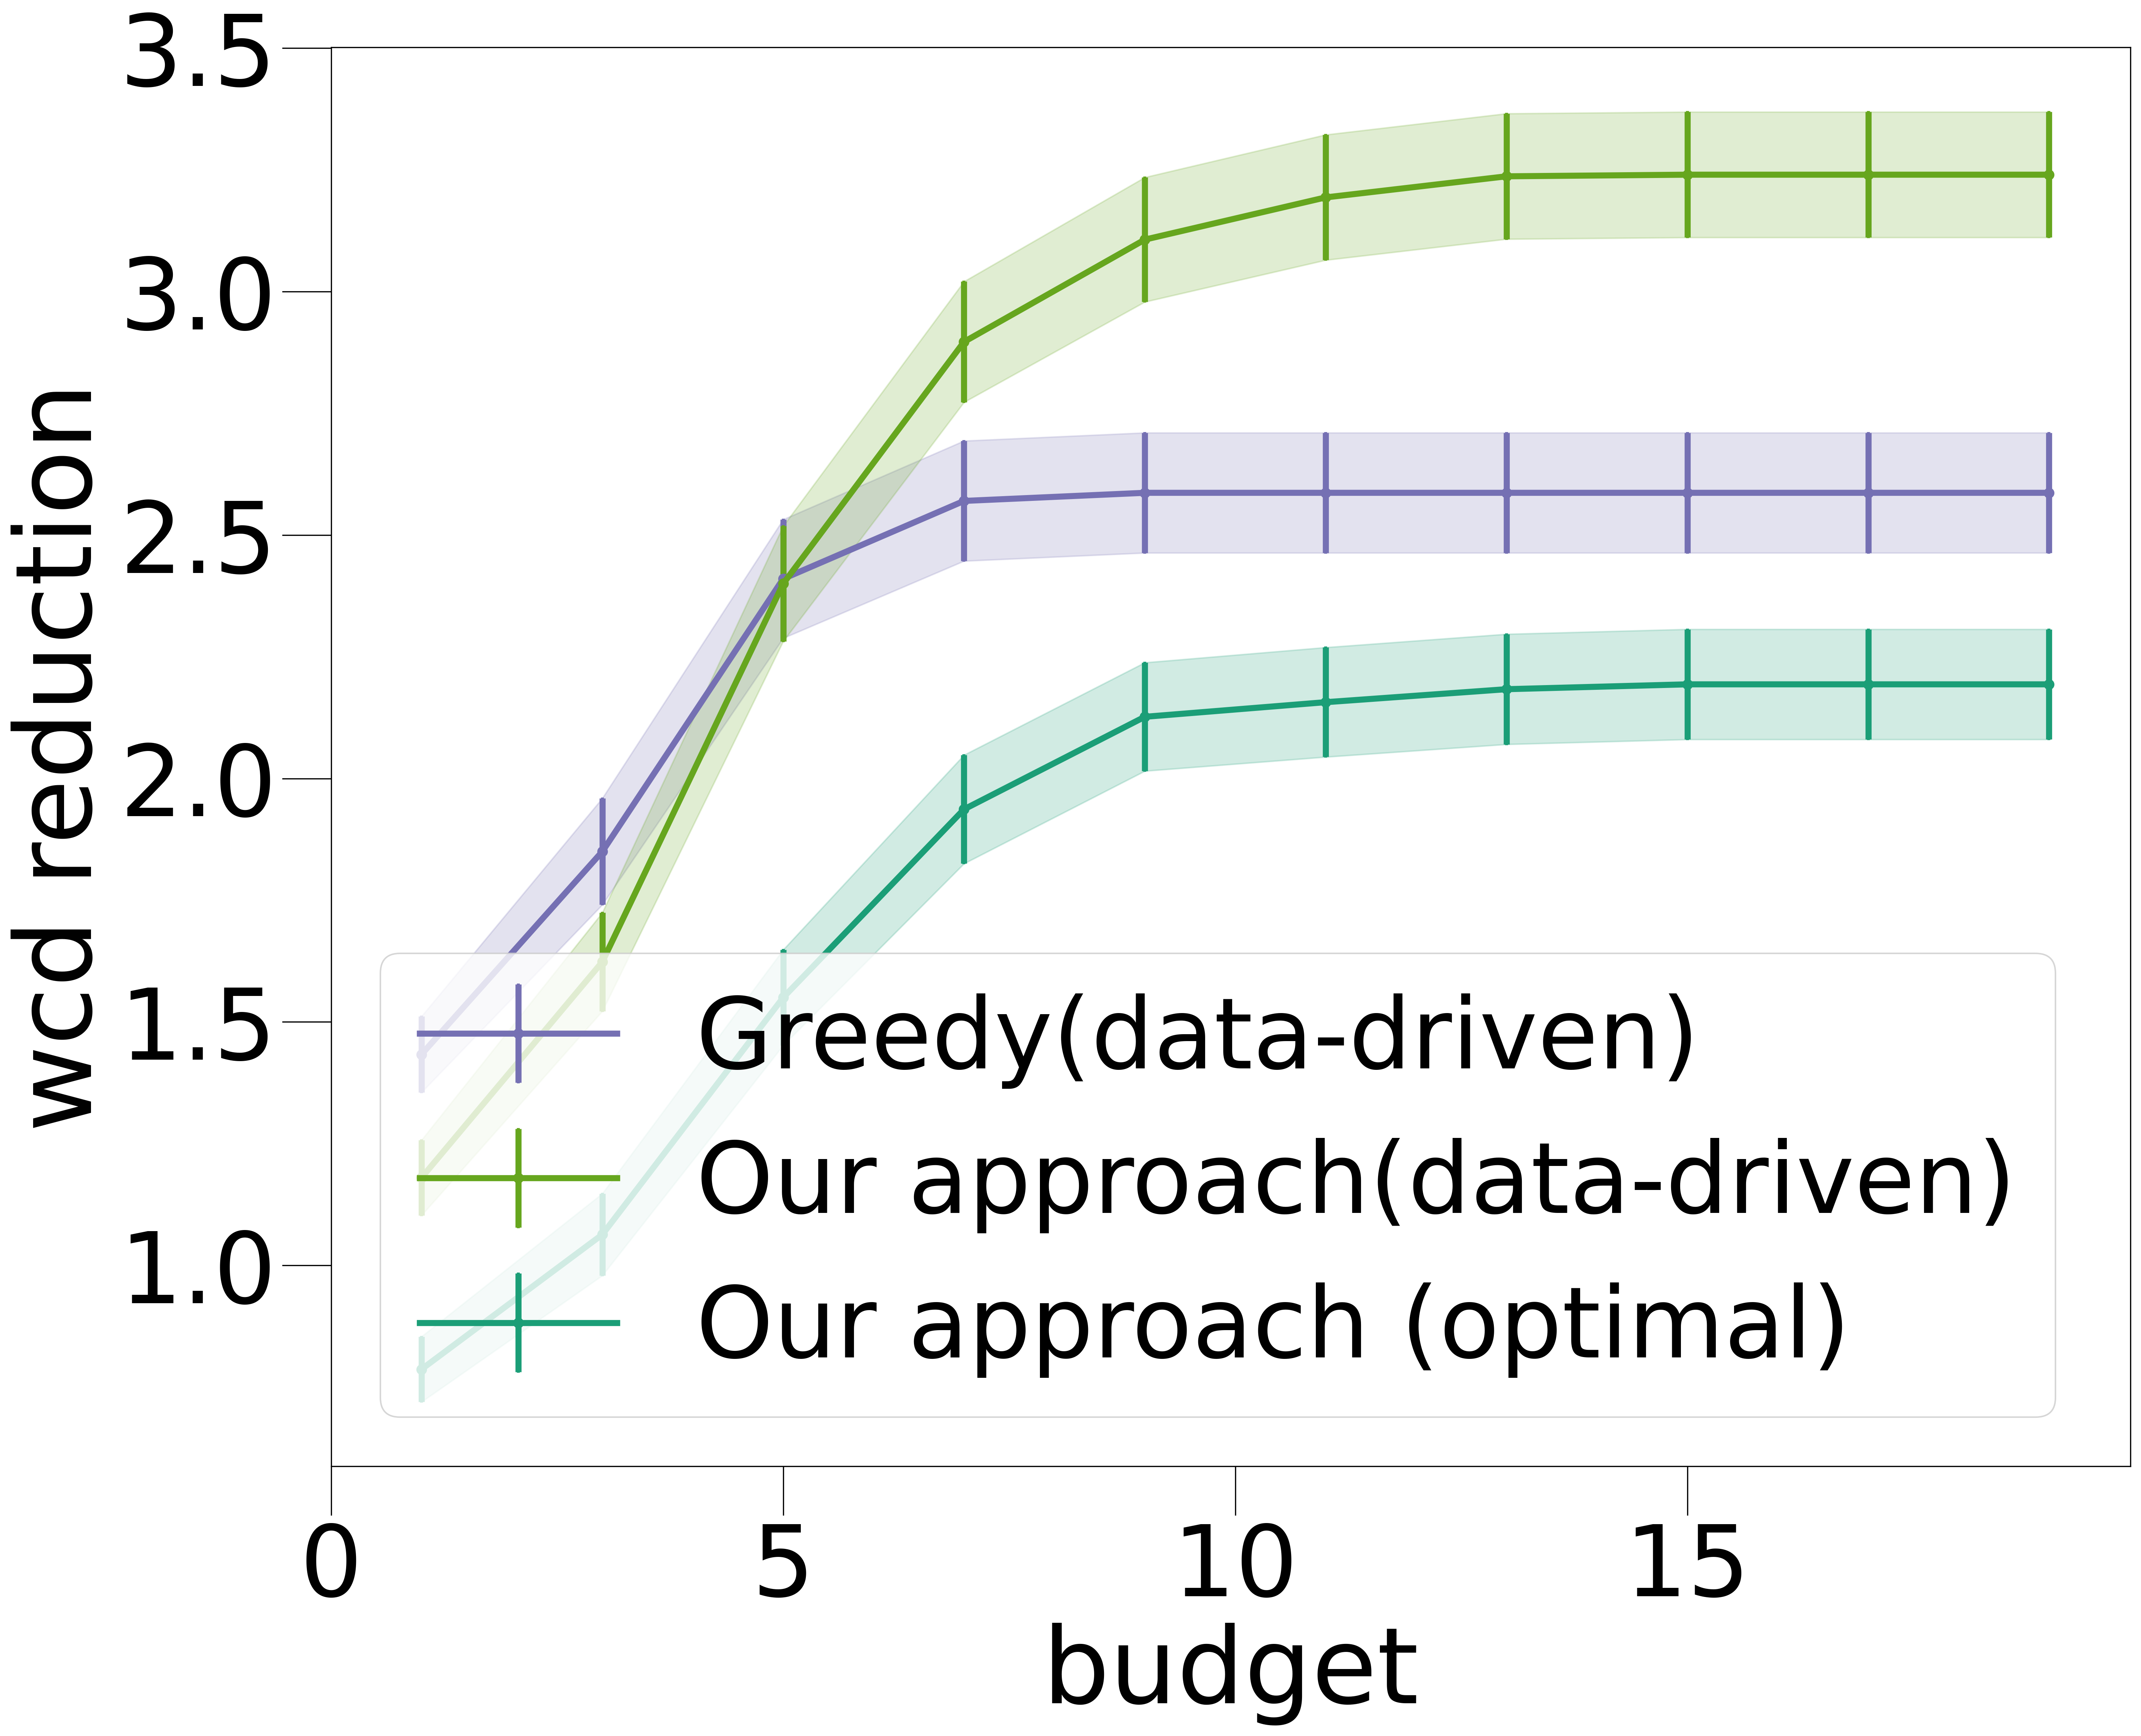

In [332]:
plot_summary(time_summary_uniform_df, 'Mean Log Time (s)', f'Uniform Modifications',
             use_given_budget = use_given_budget,show_std_err= True,show_title=show_title,
            filename =f"time/time_{GRID_SIZE}_{time_out}_uniform_cost.{file_type}",use_log_scale = True,smoothing_window=smoothing_window)

# Plotting WCD Change
plot_summary(wcd_summary_uniform_df, 'wcd reduction', f'Uniform Modifications',
             use_given_budget = use_given_budget, show_title=show_title,
            filename =f"wcd_reduction/grid{GRID_SIZE}_wcd_reduction_human_exp_comparisons.{file_type}",smoothing_window=smoothing_window)

In [333]:
# optimal_wcd_change = np.array(read_csv('./data/grid6/OPTIMAL/OPTIMAL_BOTH_UNIFORM_test/n_lambdas_17/wcd_change_6_OPTIMAL_BOTH_UNIFORM_test.csv'))
# human_wcd_change = np.array(read_csv('./data/grid6/HUMAN/HUMAN_BOTH_UNIFORM_test/n_lambdas_17/wcd_change_6_HUMAN_BOTH_UNIFORM_test.csv'))
# optimal_wcd_change = optimal_wcd_change[0:140]
# human_wcd_change=human_wcd_change[0:140]
# difference = human_wcd_change-optimal_wcd_change
# mean_difference = difference.mean(axis = 1)

# top_n_indices = np.argsort(mean_difference)[::-1][:30]
# top_n_indices